# Load packages

In [1]:
import firedrake
import numpy as np
import pickle as pkl
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl
import tqdm
import emcee
import corner
import itertools
import xarray
import dtscalibration
import glob

%matplotlib widget

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# 1. Load borehole temperatures

In [22]:
avg_temps = pd.read_pickle('Borehole_Temps/avg_temps.pkl')
residual_temps = pd.read_pickle('Borehole_Temps/residual_temps.pkl')

# Distances gotten from the QGIS file and slope tool that shows the profile and dot where cursor is
borehole_distances = {
    'ALHIC1903': 2030.299,
    'ALHIC1902': 435.741, # original 'ALHIC1902': 285.741,
    'ALHIC1901': 3230.93, # original 'ALHIC1901': 3155.93,
    'ALHIC2201': 3067.217,
    'ALHIC2301': 161.558,
    'ALHIC2302': 435.032, # original  'ALHIC2302': 257.032,
    'ALHIC2401': 171.558,
}

# Heights are adjusted to match the meshes
borehole_zs = {
    'ALHIC1903': avg_temps['ALHIC1903_23'][0].values-1,
    'ALHIC1902': avg_temps['ALHIC1902_23'][0].values,
    'ALHIC1901': avg_temps['ALHIC1901_22'][0].values,
    'ALHIC2201': avg_temps['ALHIC2201_23'][0].values -1,
    'ALHIC2301': avg_temps['ALHIC2301_23'][0].values +10,
    'ALHIC2302': avg_temps['ALHIC2302_24'][0].values,
    'ALHIC2401': avg_temps['ALHIC2401_24'][0].values+12,
    }

borehole_zs_residuals = {
    'ALHIC1903': residual_temps['ALHIC1903_23'][0].values-1,
    'ALHIC1902': residual_temps['ALHIC1902_23'][0].values,
    'ALHIC1901': residual_temps['ALHIC1901_22'][0].values,
    'ALHIC2201': residual_temps['ALHIC2201_23'][0].values -1,
    'ALHIC2301': residual_temps['ALHIC2301_23'][0].values +10,
    'ALHIC2302': residual_temps['ALHIC2302_24'][0].values,
    'ALHIC2401': residual_temps['ALHIC2401_24'][0].values+12,
    }

bore_temps = {
    'ALHIC1903': avg_temps['ALHIC1903_23'][2].values,
    'ALHIC1902': avg_temps['ALHIC1902_23'][2].values,
    'ALHIC1901': avg_temps['ALHIC1901_22'][2].values,
    'ALHIC2201': avg_temps['ALHIC2201_23'][2].values,
    'ALHIC2301': avg_temps['ALHIC2301_23'][2].values,
    'ALHIC2302': avg_temps['ALHIC2302_24'][2].values,
    'ALHIC2401': avg_temps['ALHIC2401_24'][2].values,
    }
bore_temps_residual = {
    'ALHIC1903': residual_temps['ALHIC1903_23'][2],
    'ALHIC1902': residual_temps['ALHIC1902_23'][2],
    'ALHIC1901': residual_temps['ALHIC1901_22'][2],
    'ALHIC2201': residual_temps['ALHIC2201_23'][2],
    'ALHIC2301': residual_temps['ALHIC2301_23'][2],
    'ALHIC2302': residual_temps['ALHIC2302_24'][2],
    'ALHIC2401': residual_temps['ALHIC2401_24'][2],
    }

# 2. Define constants

If something fails, try running this cell and retrying

In [11]:
# Constants
spy = 365.25 * 24 * 60 * 60
ρ = Constant(917.0)    # kg / m^3
c = Constant(2180)     # J / kg C
k = Constant(2.22)  # W / m C
α = (k/(ρ*c)) # diffusivity
A = 3.5e-25 
n = 3
R = 8.31446261815324
act_vol = -1.74e-5
Q = 6e4 # activatyion energy J/mol

dTdz = 2e-2 #C per 100m
geo_flux = Constant(60e-3) #W/m^2

λ = Constant(10.0)    # m
grav = Constant(-9.81) #m/s^2

vel_mpy = Constant(0.50) #m/yr
vel = vel_mpy / spy

# 3. Define necessary functions

In [5]:
def ε(u):
    return sym(grad(u))

T_start = -34.00001
mag_warming = 1
years = 200
final_time = years * spy 
def surface_temperature(t):
    return T_start  + (t/final_time)*mag_warming

def profile_getter(mesh,T, borehole_depth,num_points):
    coords = mesh.coordinates.dat.data_ro
    tolerance = 200
    y_values_at_x = [y for x, y in coords if abs(x - x_loc) < tolerance]
    
    # Compute min and max y values
    if y_values_at_x:
        y_min = min(y_values_at_x)
        y_max = max(y_values_at_x)
        # print(f"At x = {x_loc}, y ranges from {y_min} to {y_max}")
    else:
        print(f"No mesh points found at x = {x_loc} (within tolerance {tolerance})")
        

    x_vals = np.linspace(x_loc, x_loc, num_points)
    
    y_vals = np.linspace(y_max-borehole_depth, y_max, num_points)

    temp_profile_model_values = np.array([T.sub(0).at(x, y) for x, y in zip(x_vals, y_vals)])

    return temp_profile_model_values, y_vals

def flow_bcs(mesh, z, Y):
    w_s_divide = -0.05 / spy
    w_s_abl = 0.02 / spy
    
    divide_heights = []
    for i in mesh.coordinates.dat.data:
        if i[0] == np.max(mesh.coordinates.dat.data[:,0]):
            divide_heights.append(i[1])
    divide_depth = np.max(divide_heights) - np.min(divide_heights)
    w_divide = w_s_divide * (((z - np.min(divide_heights)) / divide_depth))
    
    abl_boundary_heights = []
    for i in mesh.coordinates.dat.data:
        if i[0] == 0:
            abl_boundary_heights.append(i[1])
    abl_depth = np.max(abl_boundary_heights) - np.min(abl_boundary_heights)
    w_abl = w_s_abl * (((z - np.min(abl_boundary_heights)) / abl_depth))
    
    bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((0, w_abl)), left_id)
    bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((0, w_divide)), right_id)
    bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), bed_id)

    # Test with zero flow along boundaries
    # bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), left_id)
    # bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), right_id)
    # bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), bed_id)
    
    bc_stokes=[bc_l, bc_b, bc_r]

    return bc_stokes

def starting_stuff(mesh):
    x, z = firedrake.SpatialCoordinate(mesh)
    element = firedrake.FiniteElement("CG", "quadrilateral", 1)
    V = firedrake.FunctionSpace(mesh, element)
    
    T = firedrake.Function(V)
    ϕ = firedrake.TestFunction(V)

    return x, z, V, T, ϕ

def temp_modeler(mesh, climate_trend, flow = True, return_profile=True):

    spy = 31557600.0
    years = 200
    δt = Constant(10*spy)
    final_time = years * spy # years modeling * spy
    num_steps = int(final_time / float(δt))
    ts = np.linspace(0.0, final_time, num_steps + 1)
    
    if flow == True:
        μ = Constant(5e15) #Ice
        x, z, V, T, ϕ = starting_stuff(mesh)

        pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
        velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
        Y = velocity_space * pressure_space
        y = firedrake.Function(Y)
        u, p = firedrake.split(y)
        v, q = firedrake.TestFunctions(y.function_space())
        
        τ = 2 * μ * ε(u)
        g = as_vector((0, grav))
        f =  ρ * g
        
        F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

        ### Flow boundary conditions ###
        bc_stokes = flow_bcs(mesh,z,Y)

        basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
        nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])
        
        stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
        parameters = {
            "nullspace": nullspace,
            "solver_parameters": {
                "ksp_type": "preonly",
                "pc_type": "lu",
                "pc_factor_mat_solver_type": "mumps",
            },
        }

        stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

        stokes_solver.solve()
        

        T_mean = climate_trend[0]+0.00001 #average temp (C)
        T_surface = Constant(T_mean)
        
        temperature_expr = T_mean - (z - 2000)*.01
        top_temp_bc = firedrake.DirichletBC(V, temperature_expr, surface_id)
        bcs_temp = [top_temp_bc]
        
        ### Defining the variational problem for temperature ###
        geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
        
        F_diffusion = k * inner(grad(T), grad(ϕ)) * dx
        F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
        
        F_0 = F_advection + F_diffusion + geothermal_flux
        
        firedrake.solve(F_0 == 0, T, bcs_temp)

        velocity_field = y.sub(0).dat.data
        temp_field = T.dat.data
        
        for i in range(100):
            prev_temp_field = copy.deepcopy(temp_field)
            prev_velocity = copy.deepcopy(velocity_field)
            ϵ_ = sym(grad(u))
            
            ϵ_effective = sqrt((inner(ϵ_, ϵ_)+tr(ϵ_)**2)*0.5)
            
            # A_new = A*exp(-((Q + (p*act_vol))/((T+273.15)*R)))
        
            A_new = A*exp(-(Q/R*( 1/(T+273.15) - 1/263))) #Does not account for melting point depression
            μ_new =  0.5*(A_new**(-1/n))*(ϵ_effective**((1/n)-1))
            
            μ_new_field = Function(V).project(μ_new)
            ϵ_effective_field = Function(V).project(ϵ_effective)
            A_new_field = Function(V).project(A_new)

            
            ### Build the stokes flow model ###
            
            pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
            velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
            Y = velocity_space * pressure_space
            
            y = firedrake.Function(Y)
            u, p = firedrake.split(y)
            v, q = firedrake.TestFunctions(y.function_space())
            
            τ = 2* μ_new * ε(u)#  2 * μ_new_field *  ϵ_
            g = as_vector((0, grav))
            f =  ρ * g
            
            F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx
        
            basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
            nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])
            stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
            parameters = {
                "nullspace": nullspace,
                "solver_parameters": {
                    "ksp_type": "preonly",
                    "pc_type": "lu",
                    "pc_factor_mat_solver_type": "mumps",
                },
            }
            stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)
        
            stokes_solver.solve()
        
            
            ### Get the new velocity field solved for ###
            velocity_field = y.sub(0).dat.data
        
        
            
            ### Build the temperature model ###
            
            F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
            F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
            geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
         
            F_0 = F_advection + F_diffusion + geothermal_flux
        
            ### Solve for the temperature field
            firedrake.solve(F_0 == 0, T, bcs_temp)
        
            ### Get the new temp field we just solved for ###
            temp_field = T.dat.data
        
            ### Calculate the residuals in the temp field ###
            residual = np.sum(np.abs((prev_temp_field - temp_field)))/temp_field.shape[0]

            if residual < 0.01: #If the residual is less than the 0.01 m/yr, let's call it good.
    
                break
            
        δx = mesh.cell_sizes.dat.data_ro[:].min()
        umax = y.sub(0).dat.data_ro[:].max()

        
        
        F = ρ * c * Dt(T) * ϕ * dx + F_advection + F_diffusion + geothermal_flux
        
        temperature_expr_stepper = T_surface - (z - 2000)*.01
        top_temp_stepper = firedrake.DirichletBC(V, temperature_expr_stepper, surface_id)
        bcs_temp = [top_temp_stepper]
        
        method = irksome.BackwardEuler()
        temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs_temp)
        
        Ts = [T.copy(deepcopy=True)]

        T_start = T_mean+0.00001

        for step in tqdm.trange(num_steps):
            t = ts[step]
            T_surface.assign(surface_temperature(t))
        
            temperature_solver.advance()
        
            Ts.append(T.copy(deepcopy=True))

        if return_profile==True:

            temp_profile_model_values, y_vals = profile_getter(mesh, T, depth_borehole.max(), num_points)

            return T, temp_profile_model_values, y_vals
        else:    
            return T, y

    else:
        μ = Constant(5e15) #Ice
        x, z, V, T, ϕ = starting_stuff(mesh)

        # Surface condition
        T_mean = climate_trend[0]+0.00001 #average temp (C)
        T_surface = Constant(T_mean)
        
        temperature_expr = T_mean - (z - 2000)*.01
        top_temp_bc = firedrake.DirichletBC(V, temperature_expr, surface_id)
        bcs_temp = [top_temp_bc]
        
        ### Defining the variational problem for temperature ###
        geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
        
        F_diffusion = k * inner(grad(T), grad(ϕ)) * dx
        
        F_0 = F_diffusion + geothermal_flux
        
        firedrake.solve(F_0 == 0, T, bcs_temp)

        δx = mesh.cell_sizes.dat.data_ro[:].min()
        δt = Constant(10*spy)
        
        F = ρ * c * Dt(T) * ϕ * dx + F_diffusion + geothermal_flux 
        

        temperature_expr_stepper = T_surface - (z - 2000)*.01
        top_temp_stepper = firedrake.DirichletBC(V, temperature_expr_stepper, surface_id)
        bcs_temp = [top_temp_stepper]
        
        method = irksome.BackwardEuler()
        temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs_temp)
        
        Ts = [T.copy(deepcopy=True)]

        T_start = T_mean+0.00001

        for step in tqdm.trange(num_steps):
            t = ts[step]
            T_surface.assign(surface_temperature(t))
        
            temperature_solver.advance()
        
            Ts.append(T.copy(deepcopy=True))

        if return_profile==True:

            temp_profile_model_values, y_vals = profile_getter(mesh, T, depth_borehole.max(), num_points)

            return T, temp_profile_model_values, y_vals
        else:    
            return T, y
   

# 4. Load the meshes

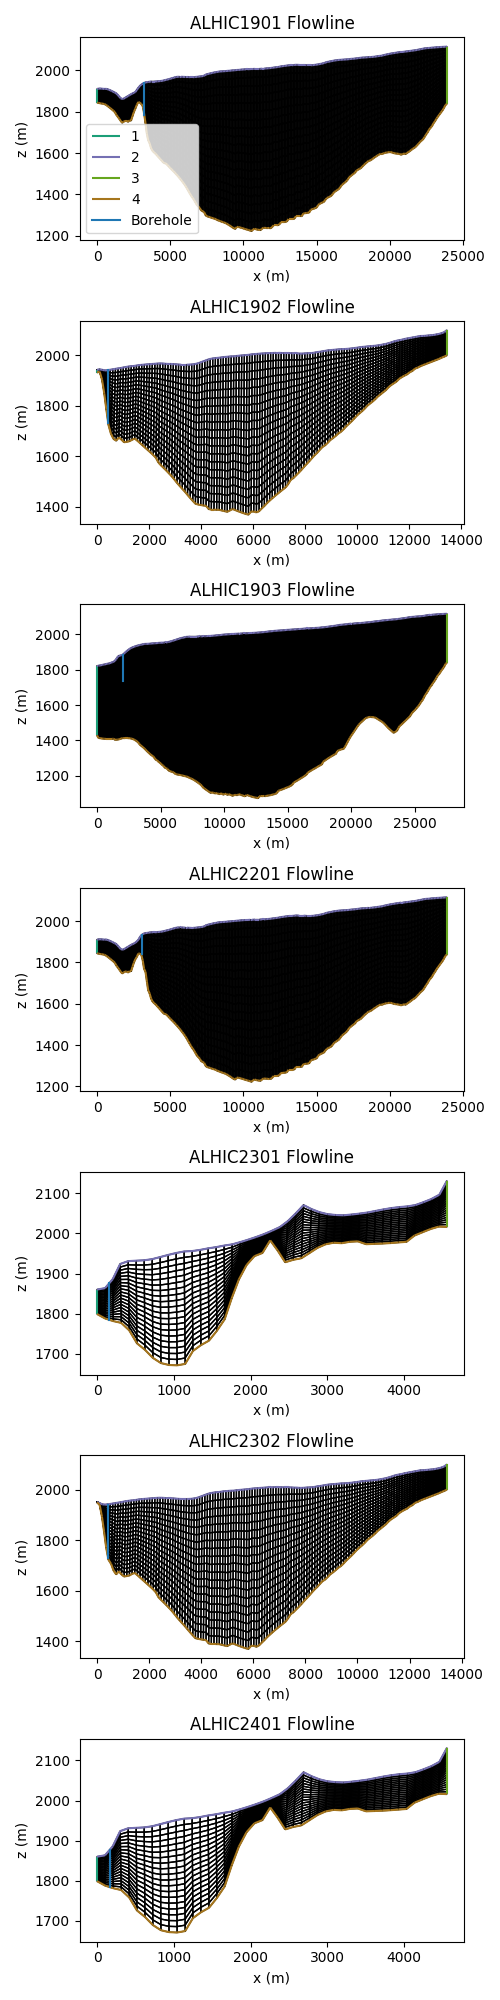

In [6]:
bed_id = [4]
left_id = [1]
surface_id = [2]
right_id = [3]

meshes = []

fig,axes = plt.subplots(len(glob.glob('Meshes/*')), 1, figsize = (5,20))

for n,mesh in enumerate(glob.glob('Meshes/*')):

    borehole_name = mesh[7:16]
    mesh = Mesh(mesh)

    

    meshes.append(mesh)
    

    axes[n].set_aspect("auto")
    axes[n].set_xlabel("x (m)")
    axes[n].set_ylabel("z (m)")
    firedrake.triplot(mesh, axes=axes[n])
    axes[n].set_title(borehole_name + ' Flowline')


    # Borehole location
    bore_z = borehole_zs[borehole_name]
    bore_x = np.array([borehole_distances[borehole_name]]*len(bore_z))
    axes[n].plot(bore_x, bore_z, label='Borehole')

    if n == 0:
        
        axes[n].legend();

plt.tight_layout()

# plt.savefig('Extra_Figs/Flowline_meshes.png', dpi=300)

# 5. Determine the initial condition and some testing too

In [7]:
def initial_conditions(mesh, climate_trend):
    μ = Constant(5e15) #Ice
    x, z, V, T, ϕ = starting_stuff(mesh)

    pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
    velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
    Y = velocity_space * pressure_space
    y = firedrake.Function(Y)
    u, p = firedrake.split(y)
    v, q = firedrake.TestFunctions(y.function_space())
    
    τ = 2 * μ * ε(u)
    g = as_vector((0, grav))
    f =  ρ * g
    
    F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

    ### Flow boundary conditions ###
    bc_stokes = flow_bcs(mesh,z,Y)

    basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
    nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])
    
    stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
    parameters = {
        "nullspace": nullspace,
        "solver_parameters": {
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
        },
    }

    stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

    stokes_solver.solve()
    

    T_mean = climate_trend[0]+0.00001 #average temp (C)
    T_surface = Constant(T_mean)

    
    temperature_expr = T_mean - (z - 2000)*.01
    top_temp_bc = firedrake.DirichletBC(V, temperature_expr, surface_id)
    bcs_temp = [top_temp_bc]
    
    ### Defining the variational problem for temperature ###
    geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
    
    F_diffusion = k * inner(grad(T), grad(ϕ)) * dx
    F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
    
    F_0 = F_advection + F_diffusion + geothermal_flux
    
    firedrake.solve(F_0 == 0, T, bcs_temp)

    return x, z, ϕ, T, y, u, V, bcs_temp

def viscosity_updater(x, z, ϕ, T, y, u, V, bcs_temp):
    velocity_field = y.sub(0).dat.data
    temp_field = T.dat.data
    
    for i in range(100):
        prev_temp_field = copy.deepcopy(temp_field)
        prev_velocity = copy.deepcopy(velocity_field)
        ϵ_ = sym(grad(u))
        
        ϵ_effective = sqrt((inner(ϵ_, ϵ_)+tr(ϵ_)**2)*0.5)
        
        # A_new = A*exp(-((Q + (p*act_vol))/((T+273.15)*R)))
    
        A_new = A*exp(-(Q/R*( 1/(T+273.15) - 1/263))) #Does not account for melting point depression
        μ_new =  0.5*(A_new**(-1/n))*(ϵ_effective**((1/n)-1))
        
        μ_new_field = Function(V).project(μ_new)
        ϵ_effective_field = Function(V).project(ϵ_effective)
        A_new_field = Function(V).project(A_new)
    
        def ε(u):
            return sym(grad(u))
        
        ### Build the stokes flow model ###
        
        pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
        velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
        Y = velocity_space * pressure_space
        
        y = firedrake.Function(Y)
        u, p = firedrake.split(y)
        v, q = firedrake.TestFunctions(y.function_space())
        
        τ = 2* μ_new * ε(u)#  2 * μ_new_field *  ϵ_
        g = as_vector((0, grav))
        f =  ρ * g
        F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx
    
        basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
        nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])
        
        bc_stokes = flow_bcs(mesh,z,Y)
        stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
        parameters = {
            "nullspace": nullspace,
            "solver_parameters": {
                "ksp_type": "preonly",
                "pc_type": "lu",
                "pc_factor_mat_solver_type": "mumps",
            },
        }
        stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)
    
        stokes_solver.solve()
    
        
        ### Get the new velocity field solved for ###
        velocity_field = y.sub(0).dat.data
    
    
        
        ### Build the temperature model ###
        
        F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
        F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
        geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
     
        F_0 = F_advection + F_diffusion + geothermal_flux
    
        ### Solve for the temperature field
        firedrake.solve(F_0 == 0, T, bcs_temp)
    
        ### Get the new temp field we just solved for ###
        temp_field = T.dat.data
    
        ### Calculate the residuals in the temp field ###
        residual = np.sum(np.abs((prev_temp_field - temp_field)))/temp_field.shape[0]
        print(residual)
        if residual < 0.01: #If the residual is less than the 0.01 m/yr, let's call it good.
            break
    return T,y, stokes_solver

# 5b. Functions for MCMC

In [8]:
geoflux_max = 120e-3
geoflux_min = 20e-3

mag_warm_max = 3
mag_warm_min = -3

T_mean_max = -25
T_mean_min = -50

### Functions ###
def log_prior(theta):

    q_geoflux, mag_warming, T_mean = theta

    if (geoflux_min < q_geoflux < geoflux_max 
    and mag_warm_min < mag_warming < mag_warm_max 
    and T_mean_min < T_mean < T_mean_max):
        return 0.0
    return -np.inf


def log_likelihood(theta, real_temp_arr):
    
    q_geoflux, mag_warming, T_mean = theta

    ### Define the temp equations
    geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
    F_diffusion = k * inner(grad(T), grad(ϕ)) * dx
    F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

    δx = mesh.cell_sizes.dat.data_ro[:].min()
    umax = y.sub(0).dat.data_ro[:].max()
    δt = Constant(10*spy)
    
    
    F = ρ * c * Dt(T) * ϕ * dx + F_advection + F_diffusion + geothermal_flux 

    T_surface = Constant(T_mean)
    temperature_expr_stepper = T_surface - (z - 2000)*.01
    top_temp_stepper = firedrake.DirichletBC(V, temperature_expr_stepper, surface_id)
    bcs_temp = [top_temp_stepper]

    method = irksome.BackwardEuler()
    temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs_temp)


    δT = 25.0
    θ = 1 * π / 2

    years = 200
    final_time = years * spy # years modeling * spy
    
    freq = 1 # 1 for annual cycle
    num_steps = int(final_time / float(δt))

    # def surface_temperature(t):
    #     return T_mean + δT * np.sin(2 * π *freq* t / year + θ) + (t/final_time)*1
    
    def surface_temperature(t):
        return T_surface  + (t/final_time)*mag_warming
        
    ts = np.linspace(0.0, final_time, num_steps + 1)
    
    surface_temps = surface_temperature(ts)
    
    Ts = [T.copy(deepcopy=True)]
    ys = [y.copy(deepcopy=True)]

    for step in np.arange(num_steps):
        t = ts[step]
        T_surface.assign(surface_temperature(t))
    
        temperature_solver.advance()
        stokes_solver.solve()
    
        Ts.append(T.copy(deepcopy=True))
        ys.append(y.copy(deepcopy=True))

    # Sample values along the line
    temp_profile_values = np.array([Ts[-1].sub(0).at(x, y) for x, y in zip(x_vals, y_vals)])

    model = np.hstack((temp_profile_values, scipy.signal.detrend(temp_profile_values[:-2])))
    sigma2 = 0.01**2
    
    ll = -0.5 * np.sum((real_temp_arr - model)**2 / sigma2 + np.log(sigma2))

    return ll
        
def log_probability(theta, real_temp_arr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    return lp + log_likelihood(theta, real_temp_arr), lp + log_likelihood(theta, real_temp_arr)

dtype = [("log_prob", float)]

# 6. Climate trend to test

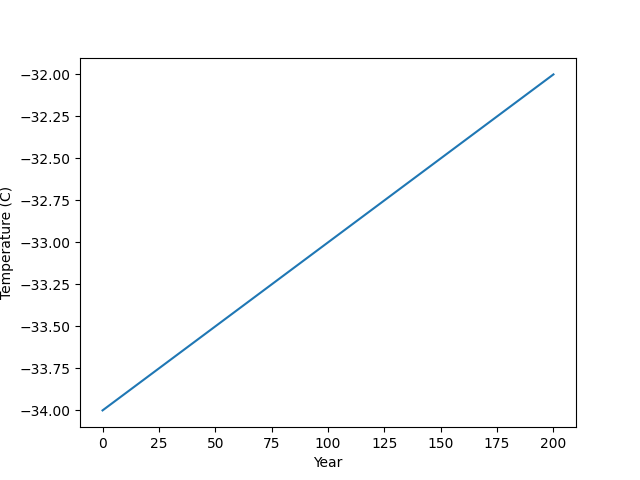

In [36]:
mag_warming = 2
δt = Constant(10*spy)
years = 200
final_time = years * spy # years modeling * spy
num_steps = int(final_time / float(δt))
ts = np.linspace(0.0, final_time, num_steps + 1)
surf_temp_model = surface_temperature(ts)


fig, ax = plt.subplots()
ax.plot(ts/spy,surf_temp_model)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (C)')
plt.show()

# 7. Initial conditions and getting the rheology

<>:66: SyntaxWarning: invalid escape sequence '\c'
<>:66: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_97654/3604046107.py:66: SyntaxWarning: invalid escape sequence '\c'
  fig.colorbar(colors, label="temperature (${}^\circ$C)")


0.06520561734737977
0.043411965266473465
0.03130272942194658
0.02243563274330264
0.015728303258482623
0.010801978380795255
0.0073143994365414584
0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.05268592304607829
0.033336987441225555
0.022174188673146605
0.014904966093036967
0.009953547555866868
0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.18425998328376988
0.1651204951359543
0.13510014100881496
0.1052092685155036
0.0771914044850403
0.0540209219965702
0.03638538666548267
0.023834866468011
0.01534923807272205
0.009767098081892385
0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.06515178260129459
0.04337422364532897
0.031280902991414845
0.022423653235942337
0.015721529900607555
0.010797412332732858
0.0073112093097900625
0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.002529270830913997
0.0
0.05
0.1
0.15
0.2
0.25
0.

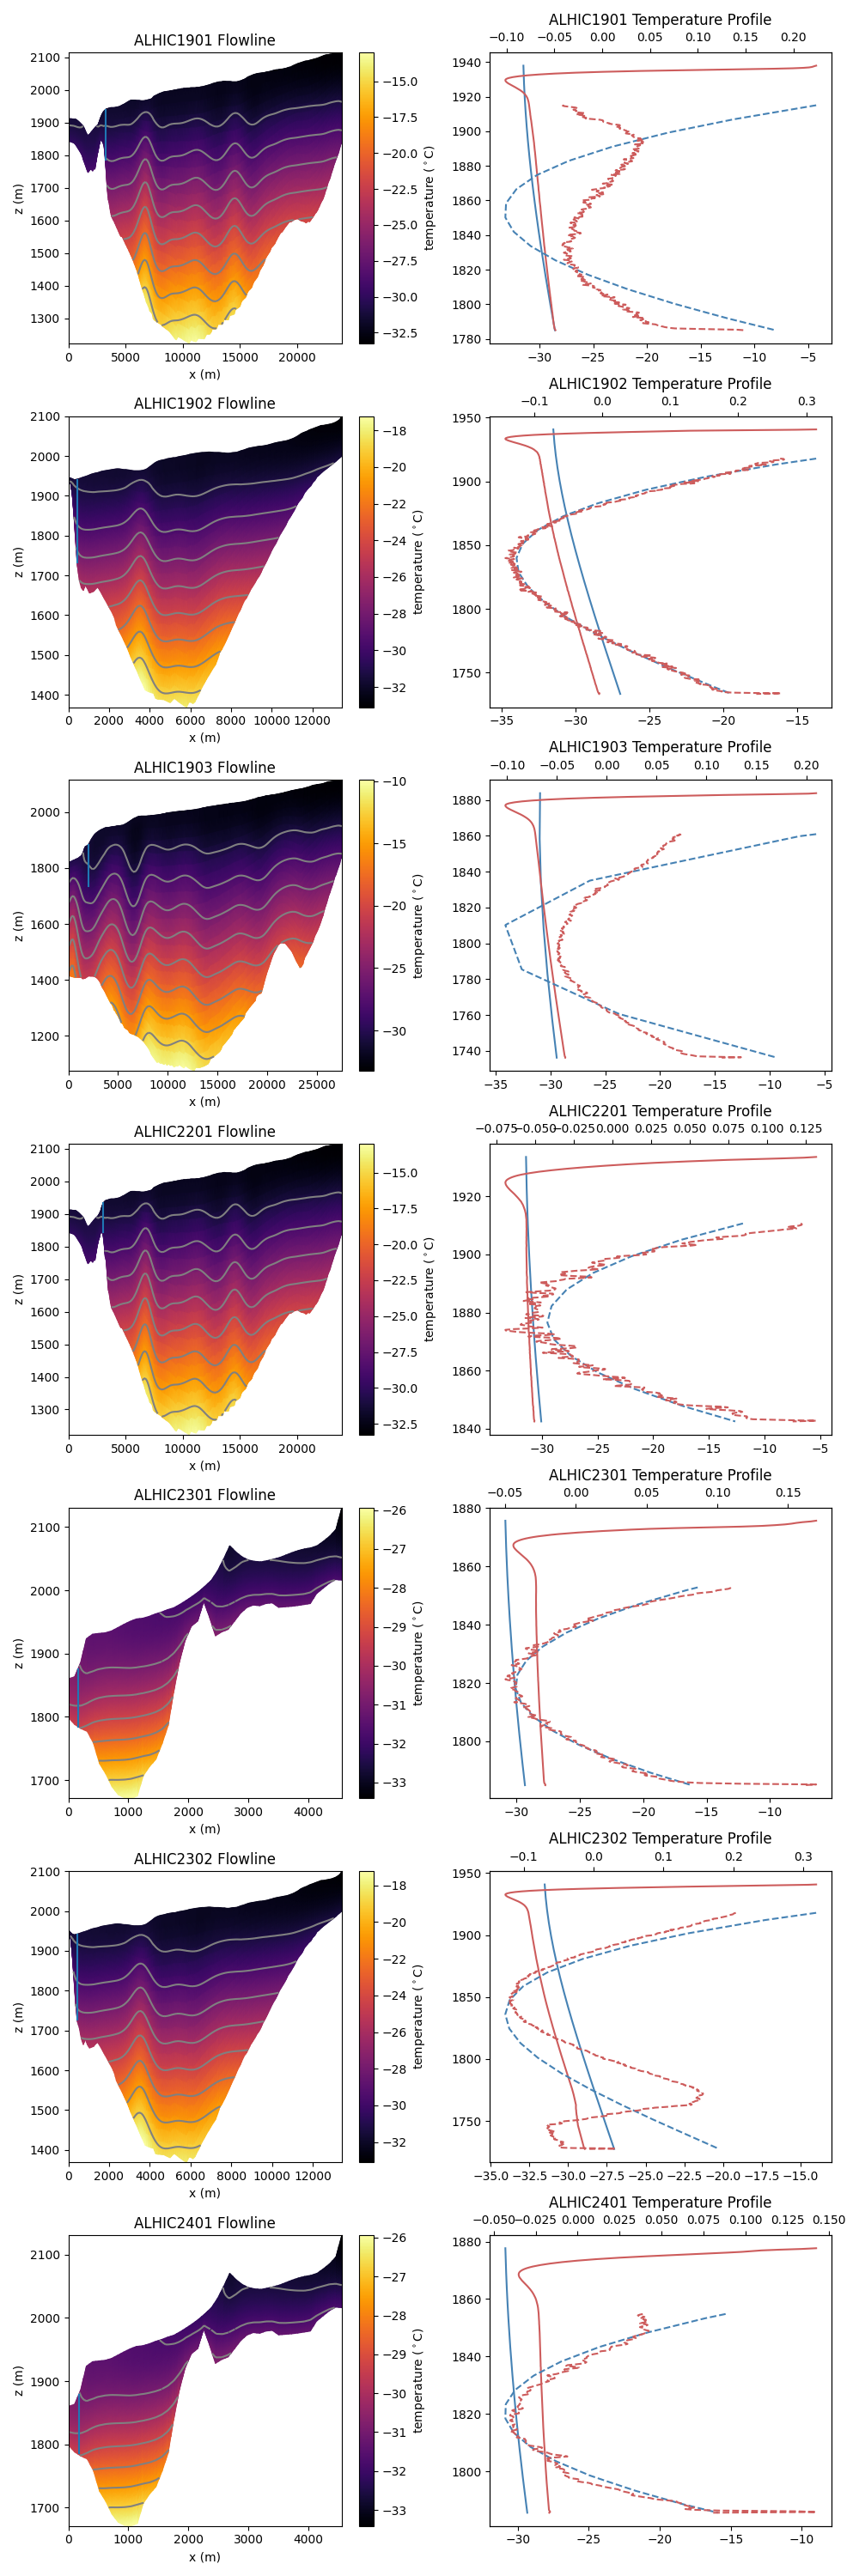

In [35]:
## If this stops working for some reason, reload the constants cell above

import scipy.signal

fig, axeses = plt.subplots(len(meshes),2, figsize=(10,30))


for num, (mesh,bore_name,axes) in enumerate(zip(meshes, glob.glob('Meshes/*'), axeses)):
    borehole_name = bore_name[7:16]


    x, z, ϕ, T, y, u, V, bcs_temp = initial_conditions(mesh, surf_temp_model)
    T_updated, y_updated, stokes_solver = viscosity_updater(x, z, ϕ, T, y, u, V,bcs_temp)
    
    ### Define the temp equations
    geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
    F_diffusion = k * inner(grad(T), grad(ϕ)) * dx
    F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

    δx = mesh.cell_sizes.dat.data_ro[:].min()
    umax = y.sub(0).dat.data_ro[:].max()
    δt = Constant(10*spy)
    
    
    F = ρ * c * Dt(T) * ϕ * dx + F_advection + F_diffusion + geothermal_flux 
    
    T_surface = Constant(surf_temp_model[0])
    temperature_expr_stepper = T_surface - (z - 2000)*.01
    top_temp_stepper = firedrake.DirichletBC(V, temperature_expr_stepper, surface_id)
    bcs_temp = [top_temp_stepper]

    method = irksome.BackwardEuler()
    temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T_updated, bcs=bcs_temp)

    def surface_temperature(t):
        return surf_temp_model[0]  + (t/final_time)*2
        
    ts = np.linspace(0.0, final_time, num_steps + 1)
    

    
    Ts = [T.copy(deepcopy=True)]
    ys = [y.copy(deepcopy=True)]

    for step in np.arange(num_steps):
        t = ts[step]
        T_surface.assign(surface_temperature(t))
        print((t/final_time))
    
        temperature_solver.advance()
        stokes_solver.solve()
    
        Ts.append(T.copy(deepcopy=True))
        ys.append(y.copy(deepcopy=True))

    bore_z = borehole_zs[borehole_name]
    bore_x = np.array([borehole_distances[borehole_name]]*len(bore_z))
    
    temp_profile_values = np.array([Ts[-1].sub(0).at(x, y) for x, y in zip(bore_x, bore_z)])


    axes[0].set_aspect("auto")
    axes[0].set_xlabel("x (m)")
    axes[0].set_ylabel("z (m)")
    colors = firedrake.tripcolor(T, cmap="inferno", axes=axes[0])
    fig.colorbar(colors, label="temperature (${}^\circ$C)")
    levels = np.linspace(T.dat.data.min(), T.dat.data.max(), 10)
    firedrake.tricontour(T, levels=levels, colors="grey", axes=axes[0])
    
    axes[0].plot(bore_x, bore_z, label='Borehole')


    axes[1].plot(temp_profile_values,bore_z, c='steelblue')
    ax_de = axes[1].twiny()
    ax_de.plot(scipy.signal.detrend(temp_profile_values[90:]),bore_z[90:], c='steelblue', ls='--')
    
    axes[1].plot(bore_temps[borehole_name],borehole_zs[borehole_name], c='indianred')
    ax_de.plot(bore_temps_residual[borehole_name],borehole_zs_residuals[borehole_name], c='indianred', ls='--')

    axes[1].set_title(borehole_name + ' Temperature Profile')
    axes[0].set_title(borehole_name + ' Flowline')
    plt.tight_layout()

plt.savefig('Extra_Figs/model_and_real_temp_comparison.png', dpi=300)